# Rapport SY23 - Prix d'hotels

## 1 - Introduction

Le projet consiste en l’étude d’un jeu de données de différents hôtels. En effet, plusieurs plaintes ont été reçues par la répression des fraudes d’un pays imaginaires. Ces plaintes ne concernent exclusivement des consommateurs basés en Europe et ayant réalisé des réservations dans des villes Européennes. L’organisme de répression des fraudes informe qu'elle souhaite concentrer les recherches sur 9 villes car, selon leurs experts métier, elles sont révélatrices du marché de l'hôtellerie en Europe.
Afin de pouvoir tester nos différents modèle, une API sera utilisée. Celle-ci permettra via la création d’avatars de pouvoir simuler des recherches d’hôtels d’après plusieurs paramètres (utilisation du téléphone, nationalité de l’avatar, destination et la durée entre le moment de réservation et le début de séjour).  Les requêtes réalisées au moyen de l’API permettront de ressortir une liste d’hôtel avec l’id de celui-ci, son prix et le nombre de chambre disponible.

## 2 - Recuperation des données

### 2.1 - 

## 3 - Préparation des données
## 4 - Les modèles
## 5 - Conclusion

## 2 - Recuperation des données

### 2.1 - Explication de l'API



## 4 - Les modèles

### 4.1 - Modele pytorch

cpu
Epoch 0 - Training Loss : 4546.249060908093 - Validation loss : 506.23138759847274 - RMSE : 22.5
Epoch 1 - Training Loss : 371.3495426507282 - Validation loss : 312.0027065779033 - RMSE : 17.664
Epoch 2 - Training Loss : 292.7984399385209 - Validation loss : 276.63605915454394 - RMSE : 16.632
Epoch 3 - Training Loss : 266.7009516585589 - Validation loss : 259.42492536076327 - RMSE : 16.107
Epoch 4 - Training Loss : 251.75957098605699 - Validation loss : 247.18782178142615 - RMSE : 15.722
Epoch 5 - Training Loss : 242.41231743647126 - Validation loss : 238.91237926483154 - RMSE : 15.457
Epoch 6 - Training Loss : 236.07920326040554 - Validation loss : 242.67234360544305 - RMSE : 15.578
Epoch 7 - Training Loss : 231.3194854058903 - Validation loss : 230.06235935395225 - RMSE : 15.168
Epoch 8 - Training Loss : 227.8566288324734 - Validation loss : 226.9035114907382 - RMSE : 15.063
Epoch 9 - Training Loss : 224.6452979456075 - Validation loss : 224.70394674518653 - RMSE : 14.99


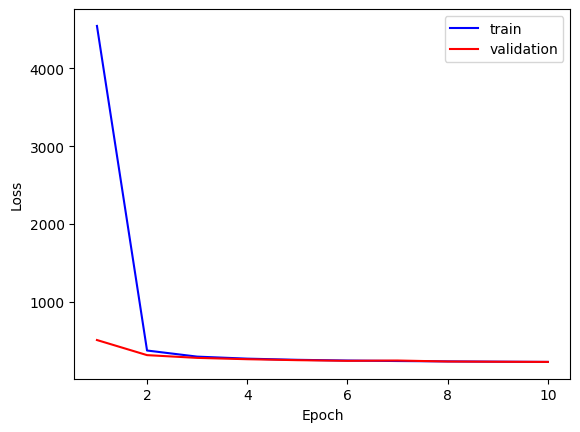

In [4]:
import torch
from datascience.model import DeepLearningModel
from torch.nn import Linear, MSELoss, Module, Dropout, BatchNorm1d
from torch import flatten
from torch.nn.functional import relu, sigmoid, tanh
import warnings
import matplotlib.pyplot as plt
%matplotlib inline

warnings.filterwarnings("ignore")


class NNModel(Module):
    def __init__(self):
        super().__init__()
        self.input = Linear(109, 109)
        self.output = Linear(109, 1)
        self.dropout = Dropout(0.2)

    def forward(self, x):
        x = tanh(self.input(x))
        return self.output(x)

    def load(self, model_path):
        self.load_state_dict(torch.load(model_path))
        self.eval()


epochs=10
model = NNModel()
nn = DeepLearningModel(model)
loss_values, val_loss_values = nn.train(epochs=epochs, learning_rate=0.001, batch_size=16, show=True)
x = list(range(1, epochs + 1))
plt.plot(x, loss_values, color='b', label='train')
plt.plot(x, val_loss_values, color='r', label='validation')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()